In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os.path
if not os.path.exists('mlp_helper.py'):
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/mlp_helper.py

In [2]:
from mlp_helper import plot_boundaries_keras, get_dataset, plot_boundaries, draw_neural_net, return_weights_notation, get_dataset_2
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 

# Pruebas a realizar:
- hidden_units en 2 y 3
- Cambiar funcion de activación de la capa oculta

# Dataset

In [30]:
hidden_units = 3

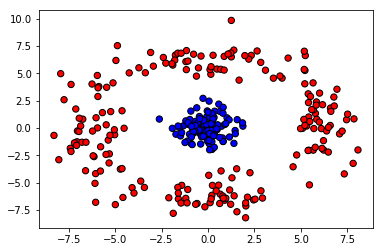

In [31]:
if hidden_units==2:
    X, y = get_dataset()
else:
    X, y = get_dataset_2()
plot_boundaries(X, y)

# Modelo

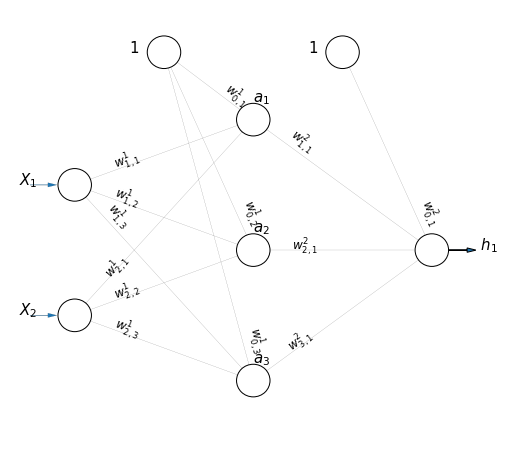

In [32]:
input_dim = 2

fig, ax = plt.subplots(1,1,figsize=(8, 8))
shape = [input_dim,hidden_units,1]
weights, biases = return_weights_notation(shape)
draw_neural_net(ax, 0.1, 0.9, 0, 0.9, shape, weights, biases)

In [33]:
from keras.models import Sequential
from keras.layers import Dense

### Selección de función de activación
https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

In [34]:
activation = 'sigmoid' # linear, tanh, relu, tanh, sigmoid

In [35]:
model = Sequential()
model.add(Dense(hidden_units, input_shape=(input_dim,), activation=activation))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento

In [36]:
from keras.optimizers import Adam, SGD
model.compile(Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model.fit(X, y, epochs=100, verbose=0)

300/300 [==============================] - 0s 774us/step


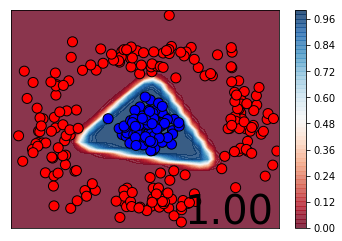

In [38]:
plot_boundaries_keras(X, y, model.evaluate(X,y)[1], probability_func=model.predict_proba, h=0.5)

## Obtenemos pesos de primera capa
### Pesos aprendidos

In [39]:
model.get_weights()

[array([[-2.2730594,  2.7388978, -0.6477428],
        [ 1.8576312,  1.3540782, -3.0649369]], dtype=float32),
 array([-8.606111 , -7.4773474, -7.9574647], dtype=float32),
 array([[-12.361407],
        [-12.282151],
        [-12.371111]], dtype=float32),
 array([5.923779], dtype=float32)]

In [40]:
# Nos quedamos con los pesos de la primer capa
layer_1_w = model.get_weights()[0]
layer_1_b = model.get_weights()[1]
print(layer_1_w)
print(layer_1_b)

[[-2.2730594  2.7388978 -0.6477428]
 [ 1.8576312  1.3540782 -3.0649369]]
[-8.606111  -7.4773474 -7.9574647]


In [41]:
# Preparo los pesos a asignar a un "submodelo" de "regresión logistica"
model_1_weights = [np.array([layer_1_w[:,0]]).T, np.array([layer_1_b[0]])]
print(model_1_weights)

[array([[-2.2730594],
       [ 1.8576312]], dtype=float32), array([-8.606111], dtype=float32)]


In [42]:
# Construimos el submodelo
model_1 = Sequential()
model_1.add(Dense(1, input_shape=(2,), activation=activation))
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Le asginamos los pesos al submodelo
model_1.set_weights(model_1_weights)
model_1.compile(Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])

300/300 [==============================] - 0s 1ms/step


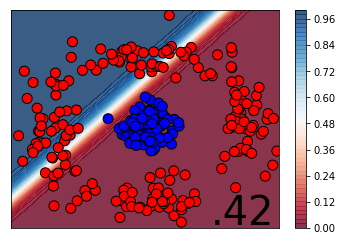

In [44]:
plot_boundaries_keras(X, y, model_1.evaluate(X,y)[1], probability_func=model_1.predict_proba, h=0.5)

### Generalizo función para armar submodelo
Y grafico los dos submodelos

In [45]:
def get_sub_model(model, index, idx1=0, idx2=1, activation='sigmoid', input_dim=2):
    layer_1_w = model.get_weights()[idx1]
    layer_1_b = model.get_weights()[idx2]
    sub_model_weights = [np.array([layer_1_w[:,index]]).T, np.array([layer_1_b[index]])]
    sub_model = Sequential()
    sub_model.add(Dense(1, input_shape=(input_dim,), activation=activation))
    sub_model.set_weights(sub_model_weights)
    sub_model.compile(Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    return sub_model

### Graficamos las rectas aprendidas por los submodelos

300/300 [==============================] - 0s 1ms/step


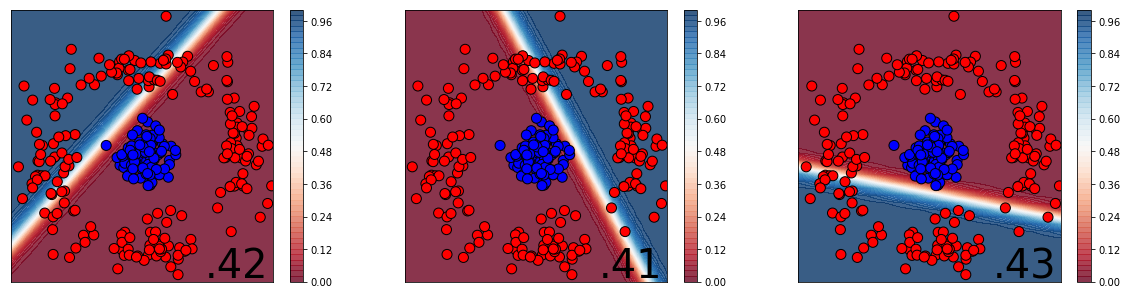

In [46]:
f, ax = plt.subplots(1, hidden_units, figsize=(20,5))
sub_models = []
for i in range(hidden_units):
    sub_model = get_sub_model(model, i, activation=activation)
    sub_models.append(sub_model)
    plot_boundaries_keras(X, y, sub_model.evaluate(X,y)[1], probability_func=sub_model.predict_proba, ax=ax[i], h=0.5)

In [47]:
# Notar que en los gráficos se ve que parece estar al reves.
model.get_weights()[2]

array([[-12.361407],
       [-12.282151],
       [-12.371111]], dtype=float32)

In [48]:
# Por eso los pesos del siguiente submodelo (el que combina los dos) son negativos

# Espacio linealmente separable

In [49]:
X_sub_preds = []
for i in range(hidden_units):
    X_sub_preds.append(sub_models[i].predict(X))

In [50]:
# Calculamos la ubicación de las observaciones en el nuevo espacio
new_space = np.hstack(X_sub_preds)

In [51]:
new_space.shape

(300, 3)

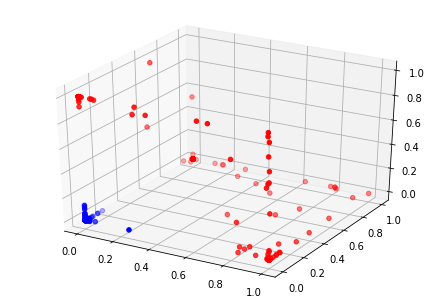

In [52]:
# Graficamos los puntos en el nuevo espacio
if hidden_units == 2:
    plt.scatter(new_space[y==1,0], new_space[y==1,1])
    plt.scatter(new_space[y==0,0], new_space[y==0,1])
    plt.show()
else:
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(new_space[y==0,0], new_space[y==0,1], new_space[y==0,2], c='r')
    ax.scatter(new_space[y==1,0], new_space[y==1,1], new_space[y==1,2], c='b')

In [53]:
# Creo el submodelo de la salida. Lleva sigmoidea por que es ya la predicción
sub_model_3 = get_sub_model(model, 0, 2, 3, activation='sigmoid', input_dim=hidden_units)

In [54]:
sub_model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [55]:
weights_3 = sub_model_3.get_weights()
weights_3

[array([[-12.361407],
        [-12.282151],
        [-12.371111]], dtype=float32), array([5.923779], dtype=float32)]

In [56]:
if hidden_units == 2:
    plot_boundaries_keras(new_space, y, sub_model_3.evaluate(new_space,y)[1], probability_func=sub_model_3.predict_proba, h=0.2)
else:
    %matplotlib widget
    N=2
    xi, yi = np.meshgrid(np.linspace(-0.5, 1.5, N), np.linspace(-0.5, 1.5, N))
    z = (- xi*weights_3[0][0, 0 ] - yi*weights_3[0][1, 0] - weights_3[1][0])/weights_3[0][2,0]
    z = z 
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xi, yi, z, alpha= 0.9)
    ax.scatter(new_space[y==0,0], new_space[y==0,1], new_space[y==0,2], c='r')
    ax.scatter(new_space[y==1,0], new_space[y==1,1], new_space[y==1,2], c='b')
    # ax.view_init(elev=20., azim=60)

    plt.show()

FigureCanvasNbAgg()